In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

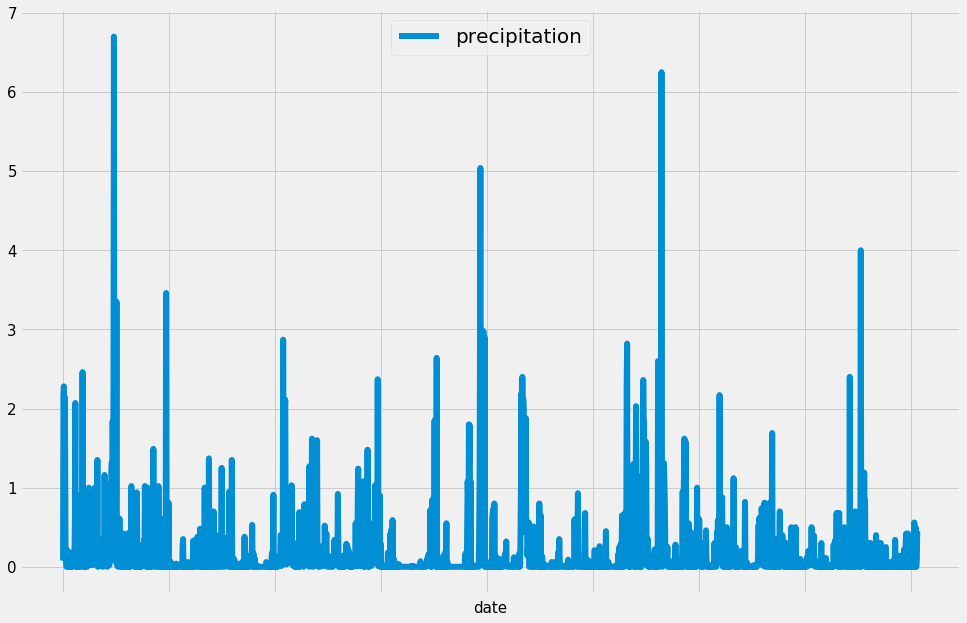

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

Last12MonthPPTQuery = "select * from Measurement \
              where date > (select date((select max(date) from Measurement),'-12 month')) \
              order by date"
Last12MonthPPTData = pd.read_sql_query(Last12MonthPPTQuery, engine)
Last12MonthPPTData = Last12MonthPPTData.set_index('date')

# plot the line chart
chartSizeL = 15
chartSizeB = 10
linewidht = 6
legendSize = 20
ytickSize = 15
xtickSize = 0
xlabelSize = 15
label='precipitation'

plt.rcParams["figure.figsize"]=[chartSizeL,chartSizeB]
zz_chart1 = Last12MonthPPTData.dropna().plot(y='prcp',
                                             linewidth=linewidht,
                                             label=label)
plt.xticks(fontsize=xtickSize)
plt.legend(fontsize=legendSize, loc = 'upper center')
plt.yticks(fontsize=ytickSize)
plt.xlabel('date',fontsize=xlabelSize)
plt.grid(b=bool, which='major', axis='both')

plt.savefig('Exploratory Climate Analysis.png', dpi = 400)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summaryStatistics = Last12MonthPPTData.dropna()['prcp'].describe().reset_index()
summaryStatistics = summaryStatistics.set_index('index')
del summaryStatistics.index.name
summaryStatistics = summaryStatistics.rename(columns = {"prcp" : "precipitation"})
summaryStatistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
# Design a query to show how many stations are available in this dataset?
stationCountQ = "select count(distinct(station)) as StationCount from Measurement"
stationCountValue = pd.read_sql_query(stationCountQ, engine)
stationCountValue = [tuple(x) for x in stationCountValue.values]
stationCountValue[0][0]

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
MostActiveStationQ = "select station,count(station) as StationCount from Measurement \
                        group by station \
                        order by StationCount desc"
MostActiveStationData = pd.read_sql_query(MostActiveStationQ, engine)
MostActiveStationData = [tuple(x) for x in MostActiveStationData.values]
MostActiveStationData

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
ParamMostActiveStationQ = "select min(tobs) as MinTemp, max(tobs) as MaxTemp, Avg(tobs) as MeanTemp \
                            from Measurement where \
                            station = (select station from Measurement \
                            group by station order by count(station) desc limit 1)"
# ParamMostActiveStationQ = "select station from Measurement group by station order by count(station) desc limit 1"
ParamMostActiveStationData = pd.read_sql_query(ParamMostActiveStationQ, engine)
ParamMostActiveStationData = [tuple(x) for x in ParamMostActiveStationData.values]
ParamMostActiveStationData

[(54.0, 85.0, 71.66378066378067)]

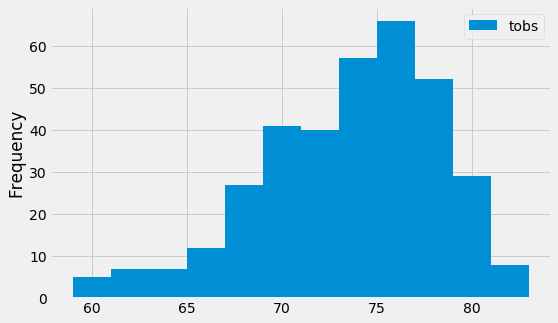

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Last12MoHighestTempObsQ = "SELECT station,date,tobs from Measurement \
              where date > (SELECT date((select max(date) from Measurement),'-12 month')) \
              and station = (select station from Measurement group by station order by count(tobs) desc limit 1) \
              order by date"
Last12MoHighestTempObsData = pd.read_sql_query(Last12MoHighestTempObsQ, engine)

# Histogram of Last12MoHighestTempObsData
chartSizeL = 8
chartSizeB = 5
bins=round((max(Last12MoHighestTempObsData['tobs'].values)-min(Last12MoHighestTempObsData['tobs'].values))/2,0)
plt.rcParams["figure.figsize"]=[chartSizeL,chartSizeB]
plt.hist(Last12MoHighestTempObsData['tobs'].values, bins=12, density=False, alpha=1, label="tobs")
plt.legend()
plt.ylabel('Frequency')
plt.savefig('Last12MonthHighestTempObs.png', dpi = 400)
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date): 
    tempValueQ = "select min(tobs) as TMIN, \
                  avg(tobs) as TAVG, max(tobs) as TMAX \
                  from Measurement where date between '" + start_date + "' and '" + end_date + "'"
    tempValueData = pd.read_sql_query(tempValueQ, engine)
    tempValueData = [tuple(x) for x in tempValueData.values]
    return tempValueData

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# plan trip for 7 days: from 2018-01-01 to 2018-01-07

TripSD = '2018-01-01'
TripED = '2018-01-07'
days_to_subtract = 365

SD = dt.strptime(TripSD,'%Y-%m-%d') - timedelta(days=days_to_subtract)
SD = SD.strftime('%Y-%m-%d')
ED = dt.strptime(TripED,'%Y-%m-%d') - timedelta(days=days_to_subtract)
ED = ED.strftime('%Y-%m-%d')

prevYearData = calc_temps(SD, ED)
print(prevYearData)

[(62.0, 68.36585365853658, 74.0)]


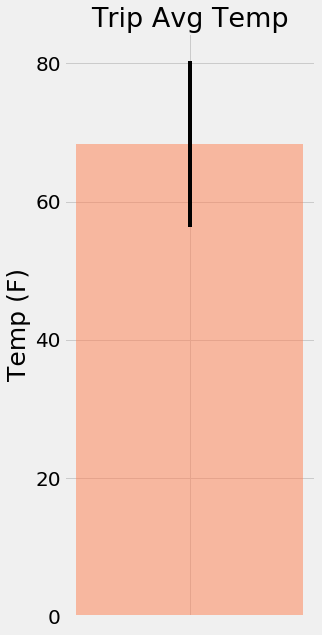

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTValue = [x[0] for x in prevYearData][0]
avgTValue = [x[1] for x in prevYearData][0]
maxTValue = [x[2] for x in prevYearData][0]

chartSizeL = 4
chartSizeB = 10
major_ticks = np.arange(0, 10*np.ceil(maxTValue/10+2), 20)
fig, ax = plt.subplots(figsize = (chartSizeL,chartSizeB))
prevYrTempChart = ax.bar(x='', height=avgTValue, yerr = maxTValue-minTValue,
                        color='coral' , align='center',alpha=0.5,ecolor='black',capsize=0)

ax.set_ylabel('Temp (F)',size = 25)
ax.set_title('Trip Avg Temp',size = 27)
ax.set_yticks(major_ticks)
plt.yticks(fontsize = 20)
plt.grid(b=bool, which='major', axis='y')
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# plan trip for 7 days: from 2018-01-01 to 2018-01-07
TripSD = '2018-01-01'
TripED = '2018-01-07'
days_to_subtract = 365

SD = dt.strptime(TripSD,'%Y-%m-%d') - timedelta(days=days_to_subtract)
SD = SD.strftime('%Y-%m-%d')
ED = dt.strptime(TripED,'%Y-%m-%d') - timedelta(days=days_to_subtract)
ED = ED.strftime('%Y-%m-%d')

TotalRainFallQ = "select M.station, sum(M.prcp) as TotalRainFall, S.name, S.latitude, S.longitude, S.elevation \
                 from Measurement as M \
                 left join Station as S \
                 on M.station = S.station \
                 where \
                 M.date between '" + SD + "' and '" + ED + "' group by M.station order by TotalRainFall desc"
#TotalRainFallData = pd.read_sql_query(TotalRainFallQ, engine).values.tolist()
TotalRainFallData = pd.read_sql_query(TotalRainFallQ, engine)
TotalRainFallData = [tuple(x) for x in TotalRainFallData.values]
# print(type(TotalRainFallData))
TotalRainFallData

[('USC00519523',
  0.61,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  0.6,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  0.6,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 0.35, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281',
  0.2,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    dailyNormalQ = "select min(tobs) as TMIN, \
                  avg(tobs) as TAVG, max(tobs) as TMAX \
                  from Measurement where date like '____-" + date + "'"
    dailyNormalData = pd.read_sql_query(dailyNormalQ, engine)
    dailyNormalData = [tuple(x) for x in dailyNormalData.values]
    return dailyNormalData

daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Optional Challenge Assignment

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

# plan trip for 7 days: from 2018-01-01 to 2018-01-07
SD = '2017-01-01'
ED = '2017-01-07'

rangeOfDates = pd.date_range(SD, ED)
rangeOfDates = rangeOfDates.strftime('%Y-%m-%d')
rangeOfDates = list(rangeOfDates.map(lambda x: x[5:len(x)]))

dailyNormalforTripDays = []

for i in rangeOfDates:
    dailyNormalforTripDays.append(daily_normals(i)[0])

dailyNormalforTripDays

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# plan trip for 7 days: from 2018-01-01 to 2018-01-07
TripSD = '2018-01-01'
TripED = '2018-01-07'
rangeOfTripDates = pd.date_range(TripSD, TripED)
rangeOfTripDates = rangeOfTripDates.strftime('%Y-%m-%d')

DF_dailyNormalforTripDays = pd.DataFrame(dailyNormalforTripDays, columns=['tmin','tavg','tmax'])
DF_dailyNormalforTripDays['date']=rangeOfTripDates
DF_dailyNormalforTripDays = DF_dailyNormalforTripDays.set_index('date')
DF_dailyNormalforTripDays

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


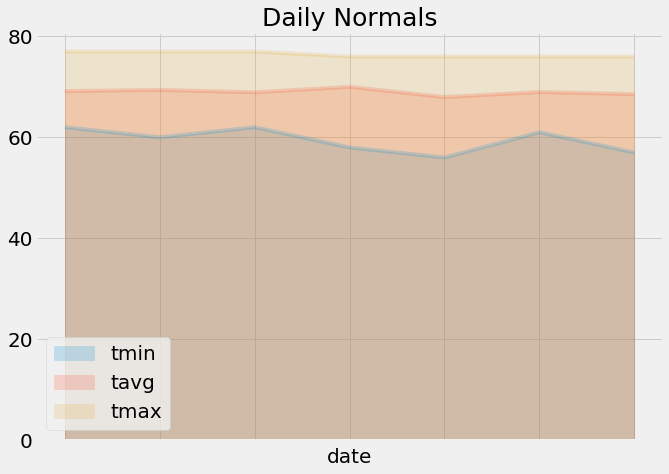

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
# x axis will be the index column, y axis remaining columns
# DF_dailyNormalforTripDays

chartSizeL = 10
chartSizeB = 7
label='Daily Normals'
legendSize = 20
ytickSize = 20
xtickSize = 20
xlabelSize = 20
titleSize = 25
xtickRotation = 30
major_ticks = np.arange(0, 10*np.ceil(max(DF_dailyNormalforTripDays['tmax'].values)/10+2), 20)

plt.rcParams["figure.figsize"]=[chartSizeL,chartSizeB]
DF_dailyNormalforTripDays.plot(kind='area', stacked=False, alpha=0.2)

plt.title(label,size = titleSize)
plt.xticks(fontsize=xtickSize, rotation=xtickRotation, ha='right')
plt.legend(fontsize=legendSize, loc = 'lower left')
plt.yticks(major_ticks,fontsize=ytickSize)
plt.xlabel('date',fontsize=xlabelSize)
plt.grid(b=bool, which='major', axis='both')


plt.savefig('DailyNormal.png',dpi=400)
plt.show()